Notebook used for training and comparing three classifiers

Data Loading and Preprocess

In [141]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import os
from data_input import LoadData
import matplotlib.pyplot as plt

In [ ]:
data_dir = '/mnt/c/senior_project/data'
df_arr = []
control_arr = []
session_folders = []
skilled_session = ['session_2', 'session_3', 'session_4', 'session_8', 'session_9', 'session_11']

In [143]:
session_folders = []
for _, folders, _ in os.walk(data_dir):
    for player_type in folders:
        player_dir = os.path.join(data_dir, player_type)
        for path, folders, files in os.walk(player_dir):
            for folder in folders:
                folder_dir = os.path.join(player_dir, folder)   
                session_folders.append(folder)
                for path, folders, files in os.walk(folder_dir):
                    hr_file = os.path.join(folder_dir, files[2])
                    timestamp_file = os.path.join(folder_dir, files[3])
                    tracking_file = os.path.join(folder_dir, files[4])
                    if folder in skilled_session or player_type == 'control':
                        skilled_flag = True
                    else:
                        skilled_flag = False
                    if player_type == 'control':
                        pass
                        if folder == 'session_13':
                            control_arr.append(LoadData(hr_file, tracking_file, skilled_flag, hours=-21.53611).dataframe)
                        else:
                            control_arr.append(LoadData(hr_file, tracking_file, skilled_flag, hours=7).dataframe)
                    else:
                        df_arr.append(LoadData(hr_file, tracking_file, skilled_flag, hours=7).dataframe)
print(session_folders)

['session_10', 'session_11', 'session_12', 'session_13', 'session_2', 'session_3', 'session_4', 'session_5', 'session_6', 'session_7', 'session_8', 'session_9', 'session_10', 'session_11', 'session_12', 'session_13', 'session_2', 'session_3', 'session_4', 'session_5', 'session_6', 'session_7', 'session_8', 'session_9']


In [144]:
i = 0
for df in df_arr:
    print(f"{session_folders[i]} Dataframe")
    i += 1
    print(df)

session_10 Dataframe
    Interval          HR  APM  Importance    Base HR  Label
0          0  103.500000    0           0  99.597455      0
1          1  102.167000    0           0  99.597455      0
2          2   77.882222    0           0  99.597455      0
3          3   93.507273   18           1  99.597455      0
4          4   84.485455   36           0  99.597455      0
5          5  103.463846  390           0  99.597455      0
6          6  105.291000   18           0  99.597455      0
7          7   90.891818   12           1  99.597455      0
8          8   69.440000   30           0  99.597455      0
9          9   87.947273   60           2  99.597455      0
10        10  102.586364   48           1  99.597455      0
11        11  126.890000   24           0  99.597455      0
12        12  106.355556   48           0  99.597455      0
13        13   68.810000   42           1  99.597455      0
session_11 Dataframe
    Interval          HR  APM  Importance    Base HR  Labe

In [145]:
dataframe = pd.concat(df_arr)
dataframe = dataframe.drop(columns='Interval')
print(dataframe)

            HR  APM  Importance    Base HR  Label
0   103.500000    0           0  99.597455      0
1   102.167000    0           0  99.597455      0
2    77.882222    0           0  99.597455      0
3    93.507273   18           1  99.597455      0
4    84.485455   36           0  99.597455      0
..         ...  ...         ...        ...    ...
13   56.582857   18           1  81.732931      1
14   50.083333   12           0  81.732931      1
15   64.463333   12           0  81.732931      1
16   43.765000    0           0  81.732931      1
17   54.038333   18           2  81.732931      1

[274 rows x 5 columns]


In [146]:
# define features and label columns
features = dataframe.drop(columns='Label').values
labels = dataframe['Label'].values

In [147]:
# normalize the data
scaler = StandardScaler()
features = scaler.fit_transform(features)
print(features)

[[ 1.26661924 -0.47918262 -0.65248234  2.598012  ]
 [ 1.20766669 -0.47918262 -0.65248234  2.598012  ]
 [ 0.13366104 -0.47918262 -0.65248234  2.598012  ]
 ...
 [-0.45979559 -0.40313511 -0.65248234  1.15084006]
 [-1.37518906 -0.47918262 -0.65248234  1.15084006]
 [-0.92084609 -0.36511135  2.32718702  1.15084006]]


LSTM Model

In [148]:
from lstm import LSTMModel
from create_dataset import CreateDataset
import torch
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
import torch.nn as nn


In [149]:
# convert to tensors
lstm_features = torch.tensor(features, dtype=torch.float32)
lstm_labels = torch.tensor(labels, dtype=torch.long)

In [ ]:
# setup dataset for the model
sequence_length = 5 #NOTE: adjust this as needed for different lengths
dataset = CreateDataset(lstm_features, lstm_labels, sequence_length)


In [151]:
# train and test split and create DataLoader (70-15-15 split)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [152]:
# model parameters and create model
input_size = 4
hidden_size = 16 # NOTE: hyperparameter
num_layers = 1 # NOTE: hyperparameter
num_classes = 2 # skilled or unskilled (1, -1)
lr = 0.001 # NOTE: hyperparameter
dropout_rate = 0.5 # NOTE: hyperparameter

model = LSTMModel(input_size, hidden_size, num_layers, num_classes, dropout_rate)
print(model)

LSTMModel(
  (lstm): LSTM(4, 16, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=16, out_features=2, bias=True)
)


/mnt/c/senior_project/env/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


In [ ]:
# training the model
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr)

epochs = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)
train_loss = []
train_acc = []
val_loss = []
val_acc = []
best_epoch = 0
best_loss = float('inf')

for epoch in range(epochs):
    # training loop
    model.train()
    correct = 0
    epoch_loss = []
    for sequence, label in train_loader:
        sequence, label = sequence.to(device), label.to(device)

        output = model(sequence)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss.append(loss.item())
        _, pred = torch.max(output.data, 1)
        correct += (pred == label).sum().item()
        
    epoch_loss_t = np.mean(epoch_loss)
    train_loss.append(epoch_loss_t)
    epoch_train_a = 100 * correct / train_size
    train_acc.append(epoch_train_a)

    # Validation Loop
    model.eval()
    correct = 0
    epoch_loss = []
    for sequence, label in val_loader:
        sequence, label = sequence.to(device), label.to(device)

        output = model(sequence)
        loss = criterion(output, label)

        _, pred = torch.max(output.data, 1)
        correct += (pred == label).sum().item()

        epoch_loss.append(loss.item())
        
    epoch_val_l = np.mean(epoch_loss)
    val_loss.append(epoch_val_l)
    epoch_val_a = 100 * correct / val_size
    val_acc.append(epoch_val_a)

    if epoch_val_l < best_loss:
        torch.save(model.state_dict(), 'LSTM_model.pth')
        best_loss = epoch_val_l
        best_epoch = epoch + 1

    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {epoch_loss_t:.4f}, Train Accuracy: {epoch_train_a:.4f}. Val Loss: {epoch_val_l:.4f},\
            Val Accuracy: {epoch_val_a:.4f}')

cuda
Epoch [1/100], Train Loss: 0.7091, Train Accuracy: 46.8085. Val Loss: 0.7159,            Val Accuracy: 45.0000
Epoch [2/100], Train Loss: 0.7044, Train Accuracy: 48.4043. Val Loss: 0.7126,            Val Accuracy: 50.0000
Epoch [3/100], Train Loss: 0.6935, Train Accuracy: 49.4681. Val Loss: 0.7076,            Val Accuracy: 52.5000
Epoch [4/100], Train Loss: 0.7003, Train Accuracy: 45.7447. Val Loss: 0.7040,            Val Accuracy: 55.0000
Epoch [5/100], Train Loss: 0.6911, Train Accuracy: 49.4681. Val Loss: 0.7010,            Val Accuracy: 57.5000
Epoch [6/100], Train Loss: 0.6878, Train Accuracy: 55.8511. Val Loss: 0.6969,            Val Accuracy: 57.5000
Epoch [7/100], Train Loss: 0.6777, Train Accuracy: 57.4468. Val Loss: 0.6943,            Val Accuracy: 60.0000
Epoch [8/100], Train Loss: 0.6774, Train Accuracy: 59.0426. Val Loss: 0.6903,            Val Accuracy: 60.0000
Epoch [9/100], Train Loss: 0.6792, Train Accuracy: 53.7234. Val Loss: 0.6868,            Val Accuracy: 65.0

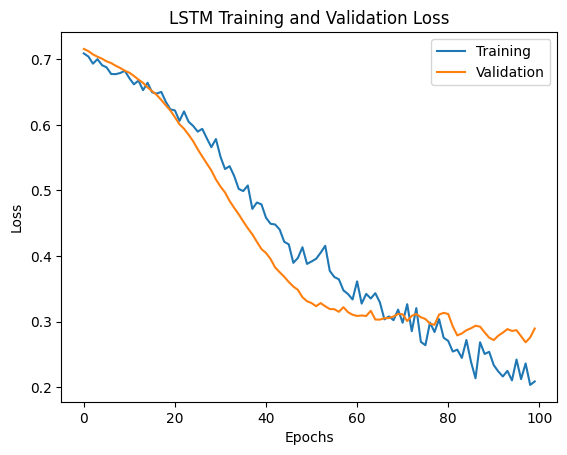

In [154]:
# plot loss over epoch
plt.plot(train_loss, label='Training')
plt.plot(val_loss, label='Validation')
plt.title('LSTM Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

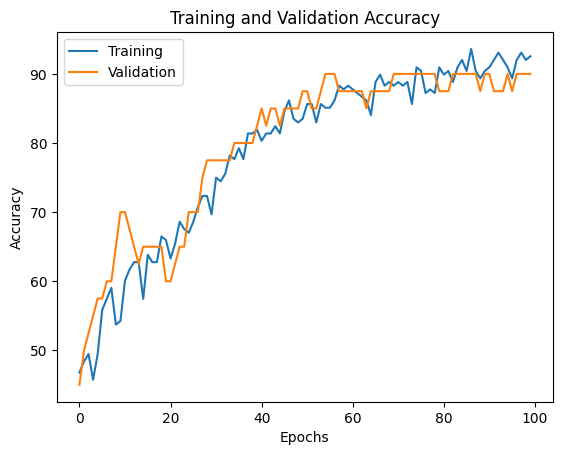

In [155]:
# plot accuracy over epoch
plt.plot(train_acc, label='Training')
plt.plot(val_acc, label='Validation')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [156]:
def evaluate_model(model, data_loader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for sequence, label in data_loader:
            sequence, label = sequence.to(device), label.to(device)
            outputs = model(sequence)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(label.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    return y_true, y_pred

In [157]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

model.load_state_dict(torch.load('LSTM_model.pth'))
y_true_LSTM, y_pred_LSTM = evaluate_model(model, test_loader)
print('LSTM Classification Report:\n', classification_report(y_true_LSTM, y_pred_LSTM))
print('LSTM Accuracy: \n', accuracy_score(y_true_LSTM, y_pred_LSTM))

LSTM Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.93      0.95        28
           1       0.86      0.92      0.89        13

    accuracy                           0.93        41
   macro avg       0.91      0.93      0.92        41
weighted avg       0.93      0.93      0.93        41

LSTM Accuracy: 
 0.926829268292683


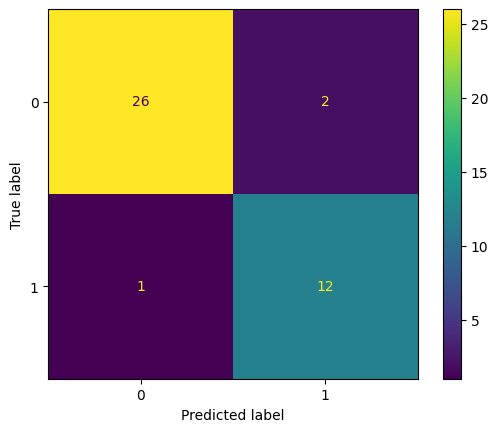

In [158]:
LSTM_cm = confusion_matrix(y_true_LSTM, y_pred_LSTM)
ConfusionMatrixDisplay(LSTM_cm).plot()

Random Forest Model

In [159]:
from random_forest import RandomForestModel

In [160]:
rf_model = RandomForestModel(X=features, y=labels)

In [161]:
rf_model.get_accuracies()

Training accuracy:  1.0
Validation accuracy:  0.9024390243902439
Test accuracy:  1.0


In [162]:
rf_model.model_report()

Random Forest Model Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        22

    accuracy                           1.00        42
   macro avg       1.00      1.00      1.00        42
weighted avg       1.00      1.00      1.00        42



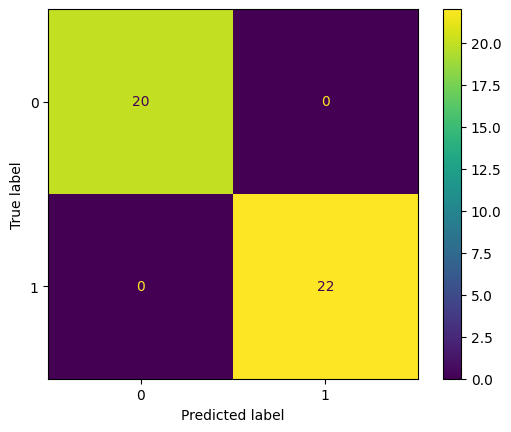

In [163]:
rf_model.plot_cm()

SVM Model

In [164]:
from svm import SVMModel

In [165]:
svm_model = SVMModel(X=features, y=labels)

In [166]:
svm_model.get_accuracies()

Training accuracy:  0.8743455497382199
Validation accuracy:  0.8048780487804879
Test accuracy:  0.8809523809523809


In [167]:
svm_model.model_report()

Random Forest Model Report:
               precision    recall  f1-score   support

           0       0.80      1.00      0.89        20
           1       1.00      0.77      0.87        22

    accuracy                           0.88        42
   macro avg       0.90      0.89      0.88        42
weighted avg       0.90      0.88      0.88        42



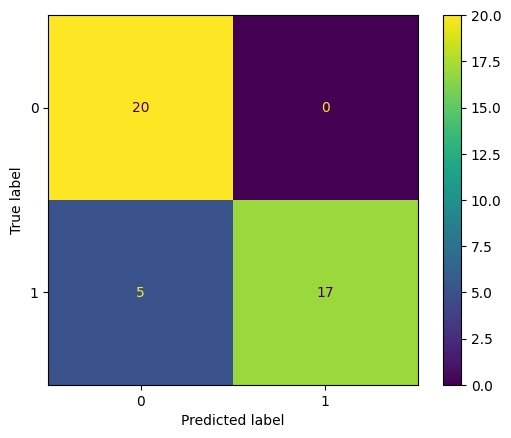

In [168]:
svm_model.plot_cm()